<a href="https://colab.research.google.com/github/mhask94/cs474_labs_f2019/blob/conv2linear/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# imports for training data
!if ( ! ls . | grep pytransform ); then git clone https://github.com/mhask94/pytransform.git; fi
# !git clone https://github.com/mhask94/pytransform.git
from pytransform.common import skew
from pytransform.quaternion import Quaternion as Quat
import numpy as np

pytransform


In [0]:
# imports for pytorch
import torch
import torch.nn as nn
from torch.autograd import Variable
from tqdm import tqdm
%matplotlib inline
import matplotlib.pyplot as plt

from IPython.core.debugger import set_trace

In [0]:
# classes for quadrotor state and dynamics
class State():
    def __init__(self, arr=np.empty(0)):
        if len(arr) == 0:
            self.arr = np.zeros((10,1), dtype=np.float64)
            self.arr[3] = 1
        else:
            assert arr.shape == (10, 1)
            if not arr.dtype == np.float64:
              arr = np.array(arr, dtype=np.float64)
            arr.dtype = np.float64
            self.arr = arr

    def __getitem__(self, position):
        return self.arr[position]
    def __str__(self):
        s = 'p: ' + str(self.p.flatten()) + '\nq: ' + self.q.__str__() + \
                '\nv: ' + str(self.v.flatten())
        s = s.replace('[ ', '[')
        s = s.replace(', ', ' ')
        s = s.replace(' ]', ']')
        return s
    def __repr__(self):
        return self.__str__()
    def __add__(self, other):
        assert other.shape == (9, 1)
        out = np.empty(self.arr.shape)
        out[:3]  = self.p + other[:3]
        out[3:7] = (self.q + other[3:6]).elements
        out[7:]  = self.v + other[6:]
        return State(out)
    def __iadd__(self, other):
        assert other.shape == (9, 1)
        self.arr[:3] += other[:3]
        self.arr[3:7] = (self.q + other[3:6]).elements
        self.arr[7:] += other[6:]
        return self
    @property
    def p(self):
        return self.arr[:3]
    @property
    def q(self):
        return Quat(self.arr[3:7])
    @property
    def v(self):
        return self.arr[7:]
    @property
    def elements(self):
        return self.arr.copy()
    def copy(self):
        return State(self.arr.copy())

class Dynamics():
    def __init__(self):
        self.k1 = np.zeros((9,1))
        self.k2 = np.zeros((9,1))
        self.k3 = np.zeros((9,1))
        self.k4 = np.zeros((9,1))
        self.cd = 0.1
        e_z = np.array([[0,0,1]]).T
        self.g = 9.8065 * e_z
        self.se = 0.5

    def run(self, xu, dt):
        x,u = State(xu[:10]), xu[10:]
        self.k1 = self.f(x, u)
        self.k2 = self.f(x + self.k1*(dt/2), u)
        self.k3 = self.f(x + self.k2*(dt/2), u)
        self.k4 = self.f(x + self.k3*dt, u)
        # x += (self.k1 + 2*(self.k2 + self.k3) + self.k4) * (dt/6)
        return x + (self.k1 + 2*(self.k2 + self.k3) + self.k4) * (dt/6)

    def f(self, x, u):
        s, w = u[0], u[1:]
        dx = np.empty(self.k1.shape)
        dx[:3] = x.q.rota(x.v)
        dx[3:6] = w
        dx[6:] = -self.g*(s/self.se) - self.cd*x.v + x.q.rotp(self.g) - \
                skew(w) @ x.v
        return dx

    @property
    def state(self):
        return self.x.copy()

In [0]:
class DataGenerator():
  def __init__(self, num_states, num_inputs, dt=0.01, batch_size=50):
    self.n = num_states
    self.m = num_inputs
    self.dt = dt
    self.batch_size = batch_size
    self.pos_lim = 300
    self.att_lim = np.pi
    self.vel_lim = 10
    self.rate_lim = 2*np.pi
    self.s_lim = 1
    self.dyn = Dynamics()

  def getRandomInput(self):
    xu = np.empty(self.n + self.m)
    xu[:2] = np.random.uniform(-self.pos_lim, self.pos_lim, 2)
    xu[2] = np.random.uniform(-self.pos_lim, 0)
    mask = np.random.uniform(size=3) > 0.2
    euler = np.random.uniform(-self.att_lim, self.att_lim, 3) * mask
    xu[3:7] = Quat.from_euler(*euler).elements.flatten()
    xu[7:10] = np.random.uniform(-self.vel_lim, self.vel_lim, 3)
    xu[10] = np.random.uniform(0, self.s_lim)
    xu[11:] = np.random.uniform(-self.rate_lim, self.rate_lim, 3)
    return xu

  def getBatch(self):
    batch_in = np.empty((self.batch_size, self.n+self.m))
    batch_out = np.empty((self.batch_size, self.n))
    for i in range(self.batch_size):
      batch_in[i] = self.getRandomInput()
      batch_out[i] = self.dyn.run(batch_in[i].reshape(-1,1), self.dt).elements.flatten()
    return batch_in, batch_out

In [5]:
def testGen():
  data_gen = DataGenerator(10,4,dt=0.01,batch_size=2)
  ran = data_gen.getRandomInput()
  print('rand: ', ran)

  x, truth = data_gen.getBatch()
  print('x: \n', x)
  print('truth: \n', truth)

  dyn = Dynamics()
  for i, state in enumerate(x):
    state = state.reshape(-1,1)
    out = dyn.run(state, 0.01).elements.flatten()
    error = out - truth[i]
    norm = np.sqrt(error @ error)
    print('norm: ', norm)

testGen()

rand:  [ 2.13414923e+02 -1.82855143e+01 -1.42148705e+02  9.23423089e-01
 -1.16868690e-01  4.58987953e-02 -3.62663492e-01 -7.38148271e+00
 -8.31359410e+00  7.43511310e+00  4.41216117e-01  1.11084338e+00
 -4.52179099e+00 -2.56110851e-01]
x: 
 [[ 7.87187309e+01  1.78633755e+02 -1.21301048e+02  8.19239931e-01
  -1.79401403e-01 -4.10309857e-01 -3.58199517e-01  9.05780015e+00
   6.21664465e-01  7.23687671e+00  4.70058091e-01 -2.52360175e+00
  -5.30594109e+00  5.18037233e+00]
 [ 2.22213428e+02  2.77736730e+01 -2.87663212e+02  5.07125555e-01
  -5.32634750e-01 -5.19049883e-01 -4.35558392e-01  5.81242695e+00
   4.16890686e+00 -9.41430763e+00  7.01144949e-01  6.16444134e+00
  -1.39895478e+00  3.35849562e+00]]
truth: 
 [[ 7.87210294e+01  1.78640415e+02 -1.21185006e+02  8.14741612e-01
  -2.09723929e-01 -4.22559587e-01 -3.37128129e-01  9.51384702e+00
  -3.87694535e-02  6.70872992e+00]
 [ 2.22265559e+02  2.76882872e+01 -2.87598782e+02  5.26896951e-01
  -5.28426518e-01 -5.26743616e-01 -4.07045675e-01 

In [6]:
def testLinearSize():
  inputs = 14
  outputs = 10
  batch = 1
  x_test = torch.zeros(batch,inputs)
  up = nn.Linear(inputs, 50)
  up_test = up(x_test)
  print('up: ', up_test.size())

  down = nn.Linear(50, outputs)
  down_test = down(up_test)
  print('down: ', down_test.size())

testLinearSize()

up:  torch.Size([1, 50])
down:  torch.Size([1, 10])


In [0]:
class ResBlock(nn.Module):
  def __init__(self, dim_in, dim_out, skip=False):
    super(ResBlock, self).__init__()
    self.skip = skip
    self.activation = nn.ReLU()
    self.layer1 = nn.Linear(dim_in, dim_in)
    self.layer2 = nn.Linear(dim_in, dim_in)
    self.layer3 = nn.Linear(dim_in, dim_out)

  def forward(self, x):
    out1 = self.activation(self.layer1(x))
    out2 = self.layer2(out1)
    skip = self.activation(out2 + out1)
    out3 = self.activation(self.layer3(skip))
    if self.skip:
      return skip, out3
    else:
      return out3

class DynamicsNN(nn.Module):
  def __init__(self, num_states, num_inputs):
    super(DynamicsNN, self).__init__()
    self.up1 = nn.Linear(num_states+num_inputs, 50)
    self.up2 = ResBlock(50,  100, skip=True)
    self.up3 = ResBlock(100, 200, skip=True)
    # self.up4 = ResBlock(200, 400, skip=True)
    self.dn1 = ResBlock(200, 100)
    self.dn2 = ResBlock(100, 50)
    self.dn3 = ResBlock(50,  num_states)
    # self.dn4 = ResBlock(50, num_states)

  def forward(self, x):
    # set_trace()
    up1 = self.up1(x)
    skip1, up2 = self.up2(up1)
    skip2, up3 = self.up3(up2)
    down1 = self.dn1(up3)
    down2 = self.dn2(skip2 + down1)
    down3 = self.dn3(skip1 + down2)
    p = down3[:,:3]
    q = down3[:,3:7]
    q1 = q / torch.norm(q, dim=1, keepdim=True)
    # mask = (q[:,0] < 0).squeeze()
    v = down3[:,7:]

    out = torch.cat((p,q1,v), dim=1)

    # out[:,3:7] /= torch.norm(out[:,3:7], dim=1, keepdim=True)
    # mask = (out[:,3] < 0).squeeze()
    # out[mask,3:7] *= -1
    return out

In [8]:
def testNet():
  n = 10
  m = 4
  x_test = torch.randn(2,n+m)
  print('x_test: ', x_test)
  net = DynamicsNN(n,m)
  test = net(x_test)
  print('shape: ', test.shape)
  print('output: ', test)

testNet()

x_test:  tensor([[ 2.7724,  2.6250, -0.2032,  2.9163, -0.2386, -0.5875,  1.0248,  0.1967,
         -2.8995, -1.0132,  2.2326,  1.0678,  0.3425,  0.5711],
        [ 0.7462,  0.8280, -1.7734,  1.0156, -0.1763, -0.2437,  0.0475, -0.0535,
          1.7576, -0.3544, -0.1903,  0.5649,  0.4224,  1.9021]])
shape:  torch.Size([2, 10])
output:  tensor([[0.0000, 0.0469, 0.0000, 0.4794, 0.0000, 0.8776, 0.0000, 0.0000, 0.0000,
         0.0929],
        [0.0000, 0.0000, 0.0000, 0.6807, 0.0000, 0.7326, 0.0000, 0.0000, 0.0000,
         0.0000]], grad_fn=<CatBackward>)



100%|██████████| 100/100 [01:05<00:00,  1.60it/s]



epoch history:  [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]

loss history:  [9.1387763671875, 8.4961376953125, 7.643990234375, 7.41815283203125, 6.7194638671875, 6.05037939453125, 6.2683408203125, 5.868318359375, 5.89025537109375, 6.0242998046875]
Nans:  2


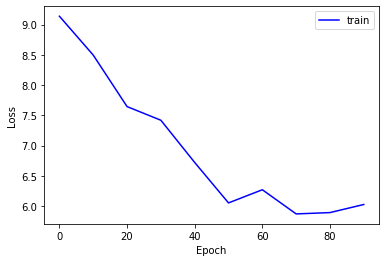

In [10]:
def train(save_model):
  n = 10
  m = 4
  dt = 0.01
  model = DynamicsNN(n, m).cuda()

  lr = 1e-2
  optimizer = torch.optim.Adam(model.parameters(), lr)
  loss_fn = nn.MSELoss()

  epochs = 100
  batch_size = 1000
  data_gen = DataGenerator(n, m, dt, batch_size)

  save_every = 10
  decay_every = 1000
  # validate_every = 1000

  epoch_hist = []
  loss_hist = []
  # vals = []

  num_nans = 0

  for epoch in tqdm(range(epochs)):
    optimizer.zero_grad()

    xu_t, x_tp1 = data_gen.getBatch()
    in_var = Variable(torch.from_numpy(xu_t).float(), requires_grad=True).cuda()
    out_truth = Variable(torch.from_numpy(x_tp1).float(), requires_grad=False).cuda()

    out_pred = model(in_var)

    # set_trace()
    loss = loss_fn(out_pred, out_truth)

    loss.backward()
    optimizer.step()

    if np.isnan(loss.item()):
      num_nans += 1

    # if epoch % validate_every == 0:
      # validate()

    if epoch % save_every == 0:
      epoch_hist.append(epoch)
      loss_hist.append(loss.item() / batch_size)
      if save_model:
        torch.save(model, 'learned_quadrotor_model.pt')
    
    if epoch % decay_every == 0:
      lr *= 0.9
      for param_group in optimizer.param_groups:
        param_group['lr'] = lr
  
  fig, ax = plt.subplots()
  train_losses, = ax.plot(epoch_hist, loss_hist, 'b', label='train')
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Loss')
  ax.legend()
  # plt.pause(0.0001)
  print('\nepoch history: ', epoch_hist)
  print('\nloss history: ', loss_hist)
  print('Nans: ', num_nans)
  plt.show()

train(save_model=False)